In [1]:
# Load the packages needed for this part
# create spark and sparkcontext objects
from pyspark.sql import SparkSession
import numpy as np

#spark = SparkSession.builder.config('','4g').getOrCreate()
spark = SparkSession.builder.config('spark.driver.memory','4g').getOrCreate()

sc = spark.sparkContext

import pyspark
from pyspark.ml import feature, regression, Pipeline
from pyspark.sql import functions as func, Row
from pyspark import sql

from pyspark.sql.functions import *
from pyspark.sql.types import IntegerType, DoubleType, FloatType

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [2]:
train_df = spark.read.csv('fraudTrain.csv', header=True, inferSchema=True)
test_df = spark.read.csv('fraudTest.csv', header=True, inferSchema=True)

In [3]:
train_df.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- trans_date_trans_time: string (nullable = true)
 |-- cc_num: long (nullable = true)
 |-- merchant: string (nullable = true)
 |-- category: string (nullable = true)
 |-- amt: double (nullable = true)
 |-- first: string (nullable = true)
 |-- last: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- street: string (nullable = true)
 |-- city: string (nullable = true)
 |-- state: string (nullable = true)
 |-- zip: integer (nullable = true)
 |-- lat: double (nullable = true)
 |-- long: double (nullable = true)
 |-- city_pop: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- dob: string (nullable = true)
 |-- trans_num: string (nullable = true)
 |-- unix_time: integer (nullable = true)
 |-- merch_lat: double (nullable = true)
 |-- merch_long: double (nullable = true)
 |-- is_fraud: integer (nullable = true)



In [4]:
# Combine train and test data and use cross validation later 
combined_df = train_df.union(test_df)
row = combined_df.count()
col = len(combined_df.columns)
print(f'Dimension of the Dataframe is: {(row,col)}')

Dimension of the Dataframe is: (1852394, 23)


In [5]:
# generating column age, day_of_week, hour_of_transaction

from pyspark.sql.functions import *
from pyspark.sql.types import IntegerType, DoubleType


# Function to calculate the distance between two adress
def haversine(lon1, lat1, lon2, lat2):
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    newlon = lon2 - lon1
    newlat = lat2 - lat1
    haver_formula = (
        np.sin(newlat / 2.0) ** 2
        + np.cos(lat1) * np.cos(lat2) * np.sin(newlon / 2.0) ** 2
    )
    dist = 2 * np.arcsin(np.sqrt(haver_formula))
    miles = 3958 * dist
    return float(miles)
    
# create a udf for implementing python function in pyspark
udf_haversine = udf(haversine, DoubleType())

def create_column(data):
    
    # day of week and the transaction hour
    data = data.withColumn('day_of_week', date_format('trans_date_trans_time', 'EEEE')) #1st col added
    data = data.withColumn('hour_of_transaction', hour('trans_date_trans_time')) #2nd col added
    
    #month_year
    data = data.withColumn('year', year('trans_date_trans_time'))
    data = data.withColumn('month', month('trans_date_trans_time'))
    data = data.withColumn('month_year', concat_ws('-', data.year ,data.month)).drop(*['year', 'month']) #3rd col added
    
    # trans_date
    data = data.withColumn("trans_date", func.to_date(func.col("trans_date_trans_time")))
    
    #age
    #data = data.withColumn("age",round(months_between(current_date(),col("dob"))/lit(12),2))
    data = data.withColumn("age",round(months_between(col('trans_date'),col("dob"))/lit(12),2))
    data = data.withColumn("age", data["age"].cast(IntegerType()))
    
    # distance between merchant and client
    # data = data.withColumn("distance", udf_haversine("long", "lat", "merch_long","merch_lat"))
    
    return data
    
combined_df = create_column(combined_df)
train_df = create_column(train_df)
test_df = create_column(test_df)

In [6]:
# finding distance between merchant and customer

udf_haversine = udf(haversine, DoubleType())
combined_df = combined_df.withColumn("distance", udf_haversine("long", "lat", "merch_long","merch_lat"))

In [7]:
combined_df.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- trans_date_trans_time: string (nullable = true)
 |-- cc_num: long (nullable = true)
 |-- merchant: string (nullable = true)
 |-- category: string (nullable = true)
 |-- amt: double (nullable = true)
 |-- first: string (nullable = true)
 |-- last: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- street: string (nullable = true)
 |-- city: string (nullable = true)
 |-- state: string (nullable = true)
 |-- zip: integer (nullable = true)
 |-- lat: double (nullable = true)
 |-- long: double (nullable = true)
 |-- city_pop: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- dob: string (nullable = true)
 |-- trans_num: string (nullable = true)
 |-- unix_time: integer (nullable = true)
 |-- merch_lat: double (nullable = true)
 |-- merch_long: double (nullable = true)
 |-- is_fraud: integer (nullable = true)
 |-- day_of_week: string (nullable = true)
 |-- hour_of_transaction: integer (nullable = true)
 |-- month_ye

In [8]:
# count unique credit cards
from pyspark.sql.functions import countDistinct
combined_df.select(countDistinct('cc_num').alias('CreditCard_Count')).show()

+----------------+
|CreditCard_Count|
+----------------+
|             999|
+----------------+



We have data of 999 credit cards. Credit card fraud detection is based on analysis of a card’s spending behaviour.
It is important to know the past transaction history of a credit card. Thus, we need to use feature engineering to create columns that can study a card's frequency of transaction in past 1 day, 1 week, 1 month and 3 months. 

In [9]:
# Adding dervided columns to understand the credit card usage behaviour Dayly, Monthly and weekly.
combined_df.createOrReplaceTempView("combined_df")

new_df = \
    spark.sql(
    """SELECT *, mean(amt) OVER (
        PARTITION BY cc_num
        ORDER BY CAST(trans_date AS timestamp) 
        RANGE BETWEEN INTERVAL 0 DAYS PRECEDING AND CURRENT ROW
     ) AS rolling_24h_avg_amt, 
     
     mean(amt) OVER (
        PARTITION BY cc_num
        ORDER BY CAST(trans_date AS timestamp) 
        RANGE BETWEEN INTERVAL 6 DAYS PRECEDING AND CURRENT ROW
     ) AS rolling_1_week_avg_amt,
     
     mean(amt) OVER (
        PARTITION BY cc_num
        ORDER BY CAST(trans_date AS timestamp) 
        RANGE BETWEEN INTERVAL 29 DAYS PRECEDING AND CURRENT ROW
     ) AS rolling_1month_avg_amt,
     
     count(_c0) OVER (
    PARTITION BY cc_num, trans_date
    ) AS number_trans_24h,
    
    count(_c0) OVER (
    PARTITION BY cc_num, day_of_week
    ) AS number_trans_specific_day,
    
    count(_c0) OVER (
    PARTITION BY cc_num, month_year
    ) AS number_trans_month,
    
    sum(amt) OVER (
        PARTITION BY cc_num
        ORDER BY CAST(trans_date AS timestamp) 
        RANGE BETWEEN INTERVAL 89 DAYS PRECEDING AND CURRENT ROW
     ) AS total_3month_amt
     
     FROM combined_df""")

new_df = new_df.withColumn('weekly_avg_amt_over_3_months',(col('total_3month_amt')/ (1.0*12)))
new_df = new_df.drop(*['total_3month_amt'])

### Creating Visualizations

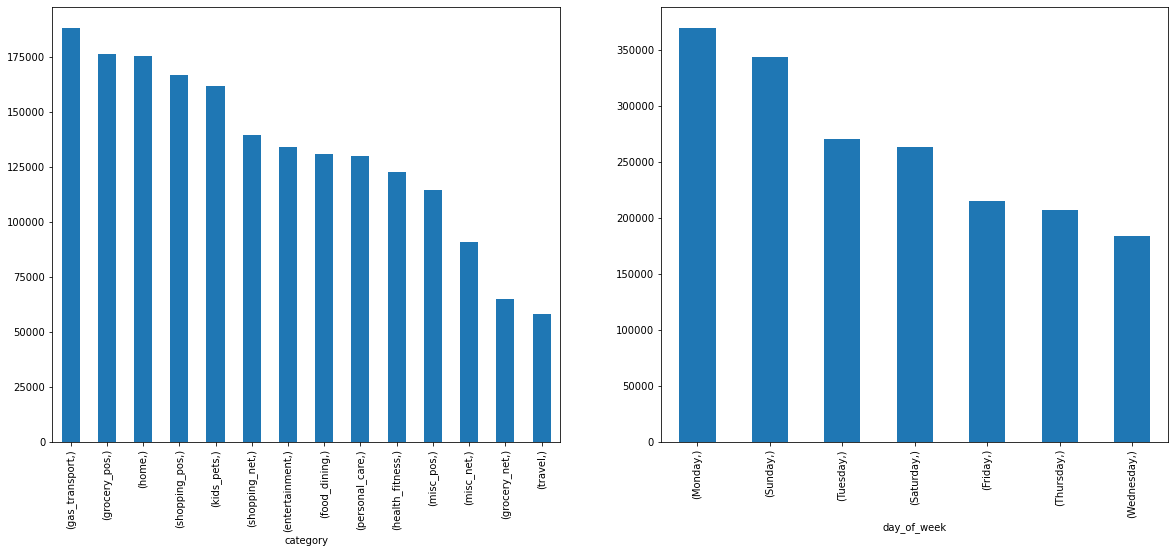

In [10]:
plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
new_df.select('category').toPandas().value_counts().plot.bar();
plt.subplot(1,2,2)
new_df.select('day_of_week').toPandas().value_counts().plot.bar();

As we can see in the above visualizations the no. of transactions happening at gas_transport category are more and for travel category are less.

Also, from the second graph we can visualize that more number of transactions happen on Monday and less on Wednesday.

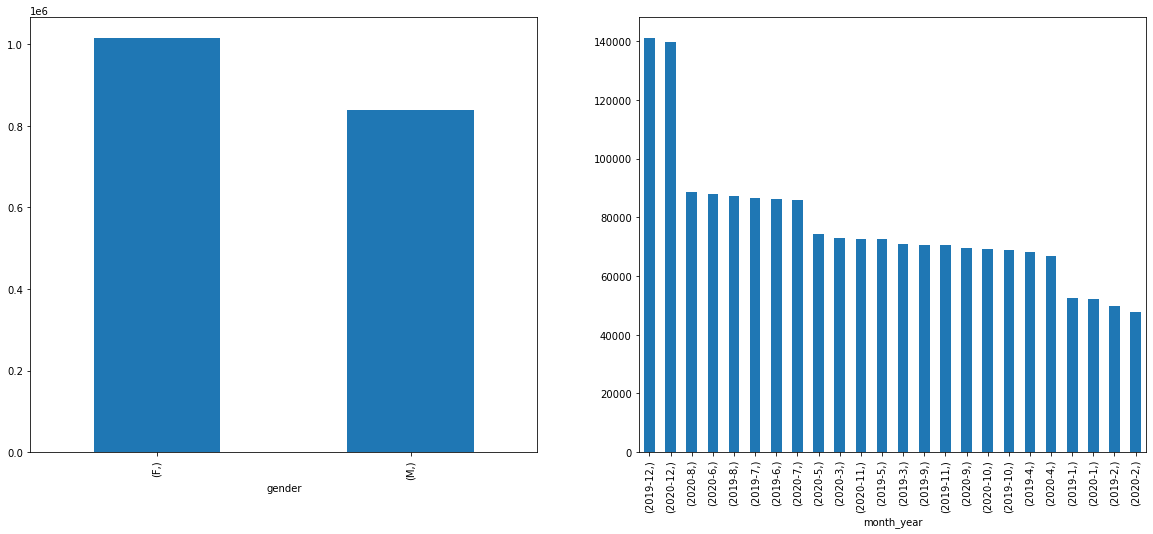

In [11]:
plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
new_df.select('gender').toPandas().value_counts().plot.bar();
plt.subplot(1,2,2)
new_df.select('month_year').toPandas().value_counts().plot.bar();

In [12]:
# changing the transdate_trans_time and dob to timestamp

new_df = new_df.withColumn('trans_date_trans_time_new', to_timestamp('trans_date_trans_time'))
new_df = new_df.drop('trans_date_trans_time')
new_df = new_df.withColumnRenamed('trans_date_trans_time_new','trans_date_trans_time')

In [13]:
new_df = new_df.withColumn('dob_new', to_date('dob'))
new_df = new_df.drop('dob')
new_df = new_df.withColumnRenamed('dob_new','dob')

In [14]:
new_df.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- cc_num: long (nullable = true)
 |-- merchant: string (nullable = true)
 |-- category: string (nullable = true)
 |-- amt: double (nullable = true)
 |-- first: string (nullable = true)
 |-- last: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- street: string (nullable = true)
 |-- city: string (nullable = true)
 |-- state: string (nullable = true)
 |-- zip: integer (nullable = true)
 |-- lat: double (nullable = true)
 |-- long: double (nullable = true)
 |-- city_pop: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- trans_num: string (nullable = true)
 |-- unix_time: integer (nullable = true)
 |-- merch_lat: double (nullable = true)
 |-- merch_long: double (nullable = true)
 |-- is_fraud: integer (nullable = true)
 |-- day_of_week: string (nullable = true)
 |-- hour_of_transaction: integer (nullable = true)
 |-- month_year: string (nullable = false)
 |-- trans_date: date (nullable = true)
 |-- age: integer 

In [15]:
np.round(new_df.select('age').toPandas().describe())

,age
count,1852394.0
mean,46.0
std,17.0
min,13.0
25%,32.0
50%,44.0
75%,57.0
max,96.0


In [16]:
new_df.select('age').describe().show()

+-------+------------------+
|summary|               age|
+-------+------------------+
|  count|           1852394|
|   mean|45.767610994205334|
| stddev| 17.41244464440168|
|    min|                13|
|    max|                96|
+-------+------------------+



33-57 age people are 50% of our customers

Minimum age of customer is 14

Maximum age of customer is 96

Modifying the age variable with Categorical distinctions as follows:

In [17]:
def udf_age_category(age):
    if (age < 25):
        return 'Age Under 25'
    elif (age >= 25 and age < 40):
        return 'Age Between 25 & 40'
    elif (age >= 40 and age < 50):
        return 'Age Between 40 & 50'
    elif (age >=50 and age < 65):
        return 'Age between 50 & 65'
    elif (age >=65):
        return 'Age Over 65'
    else: return 'N/A'

age_udf = udf(udf_age_category)

new_df = new_df.withColumn('age_udf_cat',age_udf('age'))

In [18]:
age_distribution = new_df.select('age_udf_cat').groupBy('age_udf_cat').agg(count(col('age_udf_cat')).alias('Age_Count')).sort('Age_Count', ascending = False).show(truncate = False)
age_distribution

+-------------------+---------+
|age_udf_cat        |Age_Count|
+-------------------+---------+
|Age Between 25 & 40|588955   |
|Age Between 40 & 50|433516   |
|Age between 50 & 65|377176   |
|Age Over 65        |284802   |
|Age Under 25       |167945   |
+-------------------+---------+



<AxesSubplot:xlabel='age_udf_cat'>

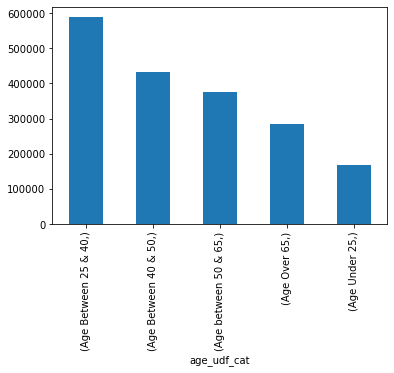

In [19]:
new_df.select('age_udf_cat').toPandas().value_counts().plot.bar()

In [20]:
np.round(((new_df.select('amt')).toPandas().describe(percentiles = [0.25,0.5,0.75,0.95,0.999])),3)

,amt
count,1852394.000
mean,70.064
std,159.254
min,1.000
25%,9.640
50%,47.450
75%,83.100
95%,195.340
99.9%,1517.241
max,28948.900


In [21]:
np.round(((new_df.select('amt').filter(col('is_fraud') == 0)).toPandas().describe(percentiles = [0.25,0.5,0.75,0.95,0.999])),3)

,amt
count,1842743.000
mean,67.651
std,153.548
min,1.000
25%,9.610
50%,47.240
75%,82.560
95%,189.590
99.9%,1519.623
max,28948.900


In [22]:
np.round(((new_df.select('amt').filter(col('is_fraud') == 1)).toPandas().describe(percentiles = [0.25,0.5,0.75,0.95,0.999])),3)

,amt
count,9651.000
mean,530.661
std,391.029
min,1.060
25%,240.075
50%,390.000
75%,902.365
95%,1084.090
99.9%,1293.127
max,1376.040


As we can see in the above distribution around 99% of total records are approximatly below 1500 amt.

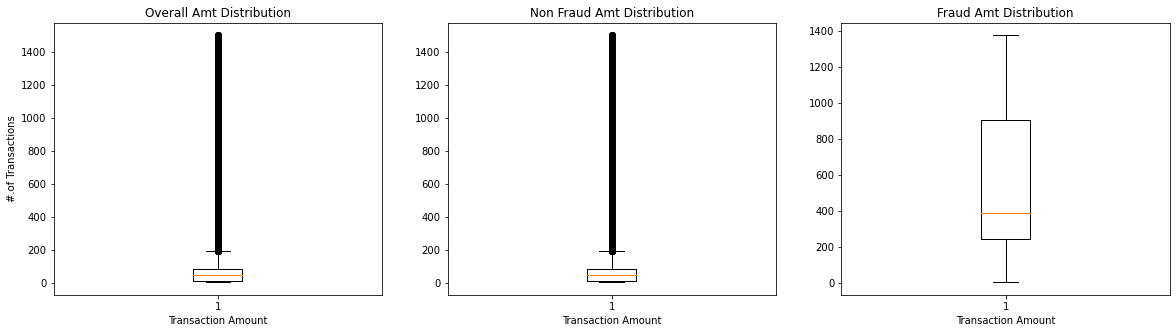

In [23]:
# boxplot distribution
fig, ax = plt.subplots(1,3,figsize=(20,5))
ax[0].boxplot((new_df.select('amt').filter(col('amt') <= 1500.0)).toPandas())
ax[1].boxplot((new_df.select('amt').filter((col('amt') <= 1500.0) & (col('is_fraud') == 0))).toPandas())
ax[2].boxplot((new_df.select('amt').filter((col('amt') <= 1500.0) & (col('is_fraud') == 1))).toPandas())

ax[0].set_title('Overall Amt Distribution')
ax[1].set_title('Non Fraud Amt Distribution')
ax[2].set_title('Fraud Amt Distribution')

ax[0].set_xlabel('Transaction Amount')
ax[0].set_ylabel('#.of Transactions')

ax[1].set_xlabel('Transaction Amount')
ax[2].set_xlabel('Transaction Amount')
plt.show()

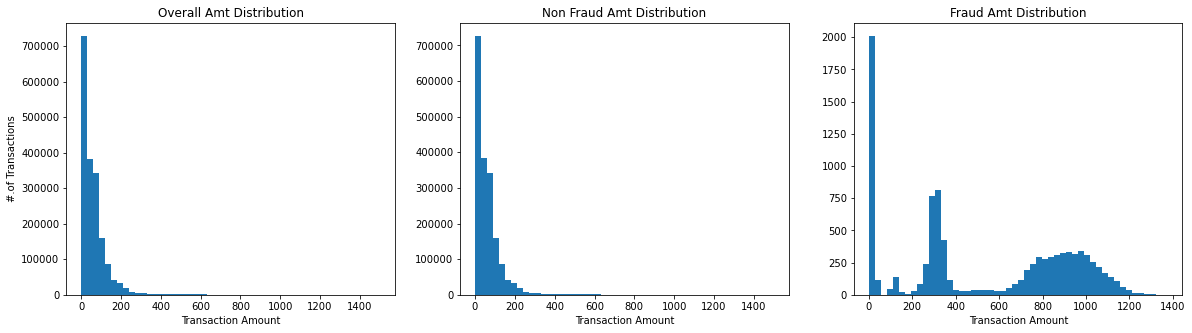

In [24]:
# histogram distribution
fig, ax = plt.subplots(1,3,figsize=(20,5))
ax[0].hist((new_df.select('amt').filter(col('amt') <= 1500.0)).toPandas(),bins = 50)
ax[1].hist((new_df.select('amt').filter((col('amt') <= 1500.0) & (col('is_fraud') == 0))).toPandas(),bins = 50)
ax[2].hist((new_df.select('amt').filter((col('amt') <= 1500.0) & (col('is_fraud') == 1))).toPandas(),bins = 50)

ax[0].set_title('Overall Amt Distribution')
ax[1].set_title('Non Fraud Amt Distribution')
ax[2].set_title('Fraud Amt Distribution')

ax[0].set_xlabel('Transaction Amount')
ax[0].set_ylabel('#.of Transactions')

ax[1].set_xlabel('Transaction Amount')
ax[2].set_xlabel('Transaction Amount')
plt.show()

### Time Series plots to understand trends

In [25]:
# used pandas to get visualizations and tables based on monthly transactions and fraud transactions. 
df = new_df.select(to_date('month_year').alias('month_year'),col('trans_num').alias('number_of_transactions'),
                                col('cc_num').alias('number_of_customers'),col('is_fraud'),col('gender'),
                                   col('category')).toPandas()

In [26]:
df_ts_month_trans = df.groupby(df['month_year'])[['number_of_transactions','number_of_customers']].nunique().reset_index()
#df_ts_month_trans = df_ts_month_trans.sort_values(by = ['month_year'])
df_ts_month_trans

,month_year,number_of_transactions,number_of_customers
0,2019-01-01,52525,913
1,2019-02-01,49866,918
2,2019-03-01,70939,916
3,2019-04-01,68078,913
4,2019-05-01,72532,910
5,2019-06-01,86064,908
6,2019-07-01,86596,910
7,2019-08-01,87359,911
8,2019-09-01,70652,913
9,2019-10-01,68758,912


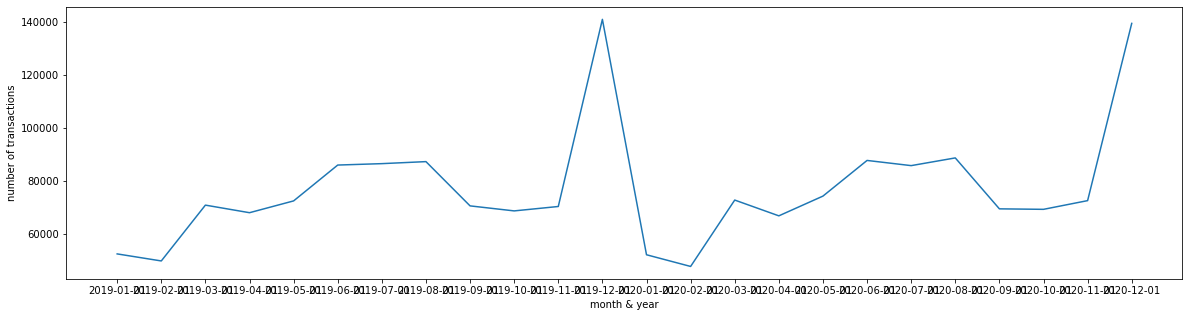

In [27]:
x = np.arange(0,len(df_ts_month_trans),1)

fig, ax = plt.subplots(1,1,figsize=(20,5))
ax.plot(x,df_ts_month_trans['number_of_transactions'])
ax.set_xticks(x)
ax.set_xticklabels(df_ts_month_trans['month_year'])

ax.set_xlabel('month & year')
ax.set_ylabel('number of transactions')
plt.show()

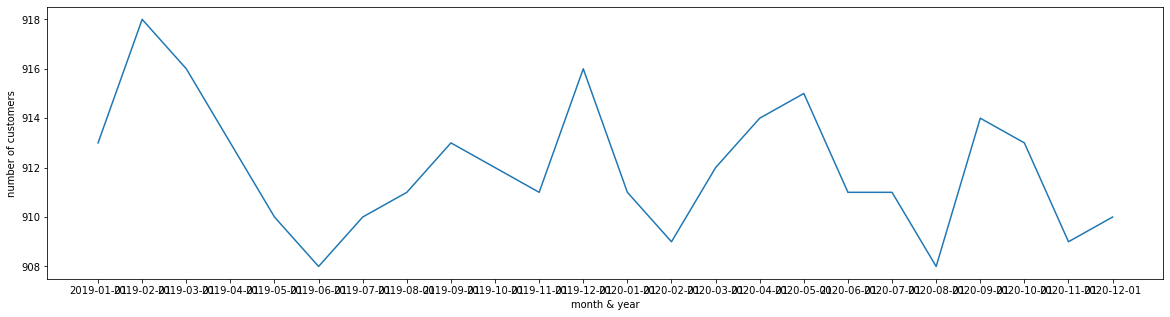

In [28]:
x = np.arange(0,len(df_ts_month_trans),1)

fig, ax = plt.subplots(1,1,figsize=(20,5))
ax.plot(x,df_ts_month_trans['number_of_customers'])
ax.set_xticks(x)
ax.set_xticklabels(df_ts_month_trans['month_year'])

ax.set_xlabel('month & year')
ax.set_ylabel('number of customers')
plt.show()

In [29]:
df_fraud_transactions = df[df['is_fraud']==1]

df_ts_fraud_month_trans = df_fraud_transactions.groupby(df_fraud_transactions['month_year'])[['number_of_transactions','number_of_customers']].nunique().reset_index()
df_ts_fraud_month_trans.columns = ['month_year','num_of_fraud_transactions','fraud_customers']
df_ts_fraud_month_trans

,month_year,num_of_fraud_transactions,fraud_customers
0,2019-01-01,506,50
1,2019-02-01,517,53
2,2019-03-01,494,49
3,2019-04-01,376,41
4,2019-05-01,408,42
5,2019-06-01,354,35
6,2019-07-01,331,36
7,2019-08-01,382,39
8,2019-09-01,418,44
9,2019-10-01,454,50


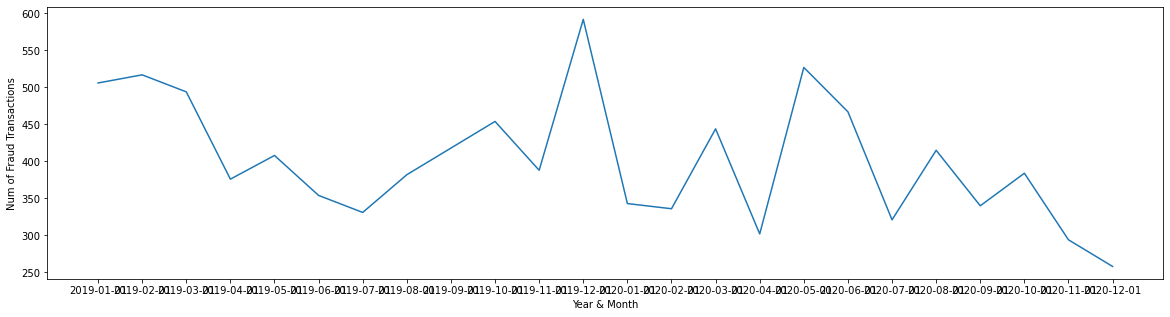

In [30]:
x = np.arange(0,len(df_ts_fraud_month_trans),1)

fig, ax = plt.subplots(1,1,figsize=(20,5))
ax.plot(x,df_ts_fraud_month_trans['num_of_fraud_transactions'])
ax.set_xticks(x)
ax.set_xticklabels(df_ts_fraud_month_trans['month_year'])

ax.set_xlabel('Year & Month')
ax.set_ylabel('Num of Fraud Transactions')
plt.show()

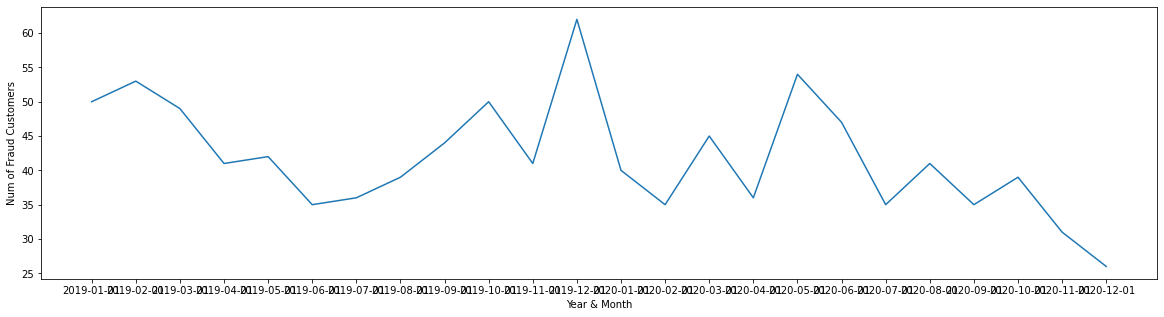

In [31]:
x = np.arange(0,len(df_ts_fraud_month_trans),1)

fig, ax = plt.subplots(1,1,figsize=(20,5))
ax.plot(x,df_ts_fraud_month_trans['fraud_customers'])
ax.set_xticks(x)
ax.set_xticklabels(df_ts_fraud_month_trans['month_year'])

ax.set_xlabel('Year & Month')
ax.set_ylabel('Num of Fraud Customers')
plt.show()

In [32]:
df_gender = df[['gender','number_of_transactions']].groupby(['gender']).count().reset_index()

df_gender.columns = ['Gender','gender_count']

df_gender['percent'] = (df_gender['gender_count']/df_gender['gender_count'].sum())*100

df_gender

,Gender,gender_count,percent
0,F,1014749,54.780408
1,M,837645,45.219592


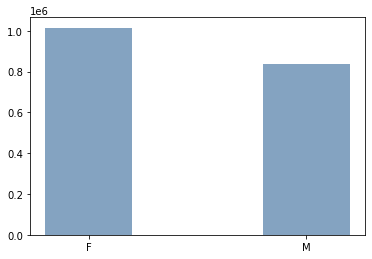

In [33]:
plt.bar(df_gender['Gender'], df_gender['gender_count'], color=(0.2, 0.4, 0.6, 0.6),  
        width = 0.4)

plt.show()

In [34]:
df_fraud_gender = df[['gender','is_fraud','number_of_transactions']].groupby(['gender','is_fraud']).count().reset_index()
df_fraud_gender.columns = ['Gender','is_fraud','count']

df_fraud_gender = df_fraud_gender.merge(df_gender[['Gender','gender_count']],how='inner',\
                                  left_on='Gender',right_on='Gender')


df_fraud_gender['percent_grp'] = (df_fraud_gender['count']/df_fraud_gender['gender_count'])*100


df_fraud_gender

,Gender,is_fraud,count,gender_count,percent_grp
0,F,0,1009850,1014749,99.517221
1,F,1,4899,1014749,0.482779
2,M,0,832893,837645,99.432695
3,M,1,4752,837645,0.567305


In [35]:
df_category = df[['category','number_of_transactions']].groupby(['category']).count().reset_index()
df_category.columns = ['Category','category_count']

df_category['percent'] = (df_category['category_count']/df_category['category_count'].sum())*100

df_category = (df_category.sort_values(by = ['percent'], ascending=False).reset_index()).drop('index',axis = 1)
df_category


,Category,category_count,percent
0,gas_transport,188029,10.150594
1,grocery_pos,176191,9.511529
2,home,175460,9.472067
3,shopping_pos,166463,8.986371
4,kids_pets,161727,8.730702
5,shopping_net,139322,7.521186
6,entertainment,134118,7.240252
7,food_dining,130729,7.057300
8,personal_care,130085,7.022534
9,health_fitness,122553,6.615925


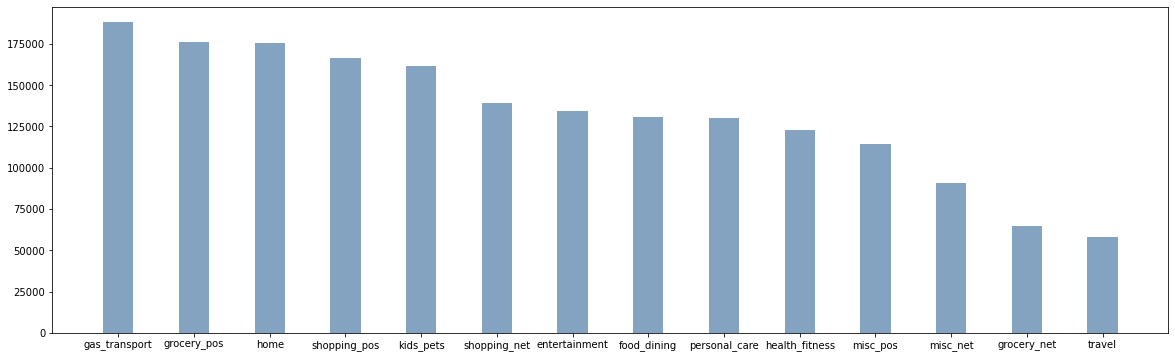

In [36]:
fig = plt.figure(figsize = (20, 6)) 


plt.bar(df_category['Category'], df_category['category_count'], color=(0.2, 0.4, 0.6, 0.6),  
        width = 0.4)

plt.show()

In [37]:
df_fraud_category = df[['category','is_fraud','number_of_transactions']].groupby(['category','is_fraud']).count().reset_index()
df_fraud_category.columns = ['Category','is_fraud','count']

df_fraud_category = df_fraud_category.merge(df_category[['Category','category_count','percent']],how='inner',\
                                  left_on='Category',right_on='Category')


df_fraud_category['percent_grp'] = (df_fraud_category['count']/df_fraud_category['category_count'])*100

df_fraud=df_fraud_category[df_fraud_category['is_fraud'] == 1].sort_values(by = ['percent_grp'])
df_fraud

,Category,is_fraud,count,category_count,percent,percent_grp
11,health_fitness,1,185,122553,6.615925,0.150955
13,home,1,265,175460,9.472067,0.151032
3,food_dining,1,205,130729,7.057300,0.156813
15,kids_pets,1,304,161727,8.730702,0.187971
1,entertainment,1,292,134118,7.240252,0.217719
21,personal_care,1,290,130085,7.022534,0.222931
27,travel,1,156,57956,3.128708,0.269170
7,grocery_net,1,175,64878,3.502387,0.269737
19,misc_pos,1,322,114229,6.166561,0.281890
5,gas_transport,1,772,188029,10.150594,0.410575


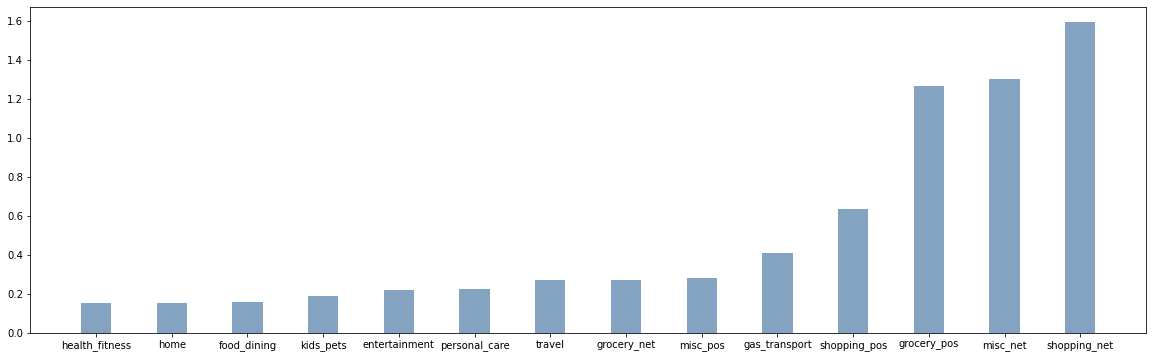

In [38]:
fig = plt.figure(figsize = (20, 6)) 


plt.bar(df_fraud['Category'] , df_fraud['percent_grp'], color=(0.2, 0.4, 0.6, 0.6),  
        width = 0.4)

plt.show()

In [39]:
cols = ['_c0', 'age', 'trans_date_trans_time', 'cc_num', 'merchant', 'first', 'last', 'street', 'city', \
        'zip', 'job', 'dob', 'state','unix_time', 'trans_num','lat', 'long','month_year', 'trans_date', 'merch_lat', 'merch_long']
preprocessed_data = new_df.drop(*cols)

In [40]:
# checking correlation between numerical features

from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler

numeric_features = [t[0] for t in preprocessed_data.dtypes if t[1] != 'string']
numeric_features_df = preprocessed_data.select(numeric_features)

# convert to vector column first
vector_col = "corr_features"
assembler = VectorAssembler(inputCols=numeric_features_df.columns, outputCol=vector_col)
df_vector = assembler.transform(numeric_features_df).select(vector_col)

# Generating Correlation Matrix
matrix = Correlation.corr(df_vector, vector_col).collect()[0][0]
corrmatrix = matrix.toArray().tolist()

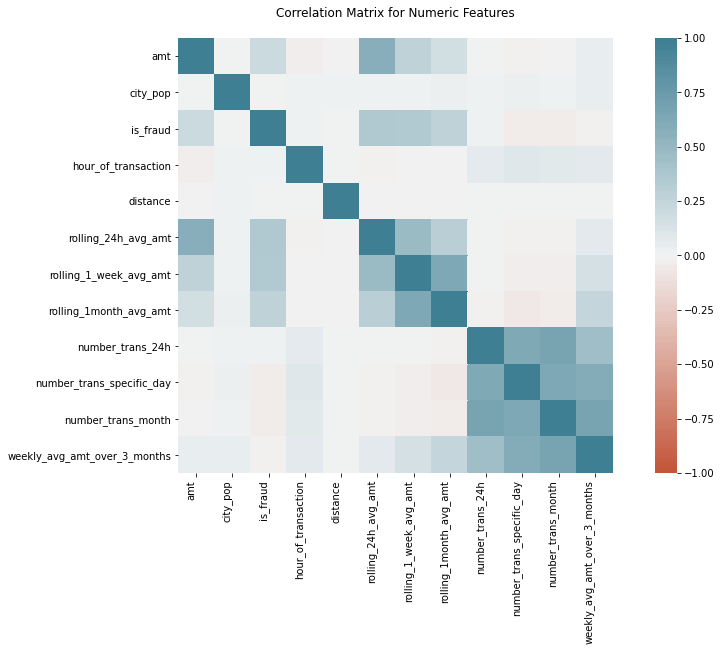

In [41]:
import seaborn as sns
plt.figure(figsize = (15,8))
ax = sns.heatmap(
    corrmatrix, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_title("Correlation Matrix for Numeric Features\n")
ax.set_xticklabels(
    numeric_features_df.columns,
    rotation=90,
    horizontalalignment='right'
);
ax.set_yticklabels(numeric_features_df.columns,
    rotation=0,
    horizontalalignment='right'
);
plt.show()

In [42]:
#spark.createDataFrame(corrmatrix,numeric_features_df.columns).toPandas()

# One-hot encoding and VectorAssembler

In [43]:
# Count of fraud transactions and non-fraud transactions
preprocessed_data.groupBy('is_fraud').count().show()

+--------+-------+
|is_fraud|  count|
+--------+-------+
|       1|   9651|
|       0|1842743|
+--------+-------+



Tried different approach for using String Indexer, One Hot encoder and vector assembler as follows:

In [44]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler

def transformColumnsToNumeric(df, inputCol):
    
    #apply StringIndexer to inputCol
    inputCol_indexer = StringIndexer(inputCol = inputCol, outputCol = inputCol + "-index").fit(df)
    df = inputCol_indexer.transform(df)
    
    onehotencoder_vector = OneHotEncoder(inputCol = inputCol + "-index", outputCol = inputCol + "-vector")
    df = onehotencoder_vector.fit(df).transform(df)
    
    return df
    
    pass

In [45]:
df = transformColumnsToNumeric(preprocessed_data, "category")
df = transformColumnsToNumeric(df, "gender")
df = transformColumnsToNumeric(df, "age_udf_cat")
df = transformColumnsToNumeric(df, "day_of_week")

In [46]:
from pyspark.ml.feature import VectorAssembler

cols = [
 'amt',
 'city_pop',
 'hour_of_transaction',
 'distance',
 'rolling_24h_avg_amt',
 'rolling_1_week_avg_amt',
 'rolling_1month_avg_amt',
 'number_trans_24h',
 'number_trans_specific_day',
 'number_trans_month',
 'weekly_avg_amt_over_3_months',
 'category-vector',
 'gender-vector',
 'age_udf_cat-vector',   
 'day_of_week-vector']

vectorAssembler = VectorAssembler().setInputCols(cols).setOutputCol('finalfeatures')
df = vectorAssembler.transform(df)

In [47]:
# creating train test set
train, validate, test = df.randomSplit([0.6, 0.3, 0.1])

In [48]:
train.groupBy('is_fraud').count().show()

+--------+-------+
|is_fraud|  count|
+--------+-------+
|       1|   5755|
|       0|1106434|
+--------+-------+



In [49]:
validate.groupBy('is_fraud').count().show()

+--------+------+
|is_fraud| count|
+--------+------+
|       1|  2945|
|       0|552489|
+--------+------+



In [50]:
test.groupBy('is_fraud').count().show()

+--------+------+
|is_fraud| count|
+--------+------+
|       1|   951|
|       0|183820|
+--------+------+



# Logistic Regression

##  Model training with 3 different parameters

In [53]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import feature, classification

# default parameters, regParam = 0.0, elasticNetParam = 0.0
lr = LogisticRegression(featuresCol='finalfeatures', labelCol='is_fraud')
lr_model = lr.fit(train)
validations_lr = lr_model.transform(validate)

# Lasso (L1) Regularization, regParam = 0.5, elasticNetParam = 0.0
lr_lasso = LogisticRegression(featuresCol='finalfeatures', labelCol='is_fraud', regParam=0.5)
lr_lasso_model = lr_lasso.fit(train)
validations_lr_lasso = lr_lasso_model.transform(validate)

# Ridge (L2) Regularization, regParam = 0.0, elasticNetParam = 0.5
lr_ridge = LogisticRegression(featuresCol='finalfeatures', labelCol='is_fraud', elasticNetParam=1.0)
lr_ridge_model = lr_ridge.fit(train)
validations_lr_ridge = lr_ridge_model.transform(validate)


# Defining the evaluator to find out the best cross validated model

from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Area under PR curve (main focus since this is imbalanced dataset)
bce_pr = BinaryClassificationEvaluator(labelCol = 'is_fraud', metricName='areaUnderPR')

# Area under ROC
bce_roc = BinaryClassificationEvaluator(labelCol = 'is_fraud')

print('Area under PR curve for Logistic Regression with no regularization: {0}'.format(bce_pr.evaluate(validations_lr)))
print('Area under ROC curve for Logistic Regression with no regularization: {0}'.format(bce_roc.evaluate(validations_lr)))
print('')

print('Area under PR curve for Logistic Regression with L1 regularization: {0}'.format(bce_pr.evaluate(validations_lr_lasso)))
print('Area under ROC curve for Logistic Regression with L1 regularization: {0}'.format(bce_roc.evaluate(validations_lr_lasso)))
print('')

print('Area under PR curve for Logistic Regression with L2 regularization: {0}'.format(bce_pr.evaluate(validations_lr_ridge)))
print('Area under ROC curve for Logistic Regression with L2 regularization: {0}'.format(bce_roc.evaluate(validations_lr_ridge)))

Area under PR curve for Logistic Regression with no regularization: 0.5432947036051969
Area under ROC curve for Logistic Regression with no regularization: 0.9590660126103625

Area under PR curve for Logistic Regression with L1 regularization: 0.44765211651665493
Area under ROC curve for Logistic Regression with L1 regularization: 0.9874267035549548

Area under PR curve for Logistic Regression with L2 regularization: 0.5430387755959999
Area under ROC curve for Logistic Regression with L2 regularization: 0.9590663116122362


##  Estimating generalization performance for no regularization model


In [54]:

predictions_lr = lr_model.transform(test)

from pyspark.sql.types import FloatType
from pyspark.mllib.evaluation import MulticlassMetrics

#select only prediction and label columns
preds_and_labels_lr = predictions_lr.select(['prediction','is_fraud']).\
                                withColumn('is_fraud', func.col('is_fraud').cast(FloatType())).orderBy('prediction')

### Confusion Matrix

In [55]:
confusion_matrix_lr = MulticlassMetrics(preds_and_labels_lr.rdd.map(tuple)).confusionMatrix().toArray()
confusion_matrix_lr

array([[1.83677e+05, 1.43000e+02],
       [5.73000e+02, 3.78000e+02]])

In [56]:
# function to plot confusion matrix. Necessary to execute next cell

class_names=[1.0,0.0]
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[   378    573]
 [   143 183677]]


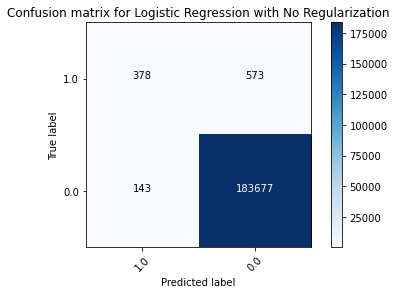

In [57]:
from sklearn.metrics import confusion_matrix

class_names=[1.0,0.0]

y_true_lr = predictions_lr.select("is_fraud")
y_true_lr = y_true_lr.toPandas()

y_pred_lr = predictions_lr.select("prediction")
y_pred_lr = y_pred_lr.toPandas()

cnf_matrix = confusion_matrix(y_true_lr, y_pred_lr,labels=class_names)
#cnf_matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix for Logistic Regression with No Regularization')
plt.show()

### Precision, Recall and F1 Score

In [45]:
precision_lr = confusion_matrix_lr[1,1]/np.add(confusion_matrix_lr[0,1], confusion_matrix_lr[1,1])
print("Precision: ",precision_lr)
recall_lr = confusion_matrix_lr[1,1]/np.add(confusion_matrix_lr[1,0], confusion_matrix_lr[1,1])
print("recall: ",recall_lr)
f1_score_lr = 2*(precision_lr*recall_lr)/(precision_lr+recall_lr)
print("f1_score: ",f1_score_lr)

Precision:  0.759765625
recall:  0.37367915465898177
f1_score:  0.5009658725048294


### Area under ROC Curve and Precision-Recall Curve

In [58]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Let's use the run-of-the-mill evaluator
evaluator = BinaryClassificationEvaluator(labelCol='is_fraud')

# We have only two choices: area under ROC and PR curves :-(
auroc_lr = evaluator.evaluate(predictions_lr, {evaluator.metricName: "areaUnderROC"})
auprc_lr = evaluator.evaluate(predictions_lr, {evaluator.metricName: "areaUnderPR"})
print("Area under ROC Curve for test data: {:.4f}".format(auroc_lr))
print("Area under PR Curve for test data: {:.4f}".format(auprc_lr))

Area under ROC Curve for test data: 0.9602
Area under PR Curve for test data: 0.5379


### Using handyspark package to draw curves

In [59]:
!pip install handyspark

distutils: /opt/conda/include/python3.8/UNKNOWN
sysconfig: /opt/conda/include/python3.8
user = False
home = None
root = None
prefix = None
     |████████████████████████████████| 25.6 MB 9.7 MB/s eta 0:00:01
distutils: /opt/conda/include/python3.8/UNKNOWN
sysconfig: /opt/conda/include/python3.8
user = False
home = None
root = None
prefix = None


<AxesSubplot:title={'center':'Precision-Recall Curve'}, xlabel='Recall', ylabel='Precision'>

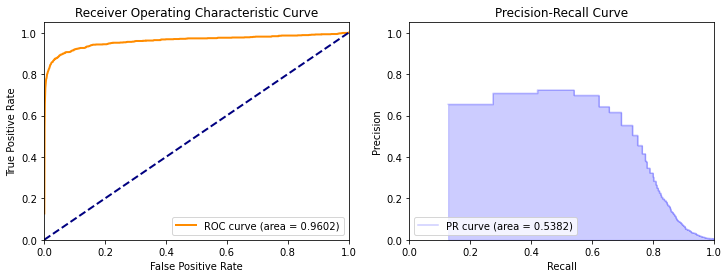

In [60]:
# !pip install handyspark
from handyspark import *
# Creates instance of extended version of BinaryClassificationMetrics
# using a DataFrame and its probability and label columns, as the output
# from the classifier
bcm = BinaryClassificationMetrics(predictions_lr, scoreCol='probability', labelCol='is_fraud')

# But now we can PLOT both ROC and PR curves!
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
bcm.plot_roc_curve(ax=axs[0])
bcm.plot_pr_curve(ax=axs[1])

# We can also get all metrics (FPR, Recall and Precision) by threshold
#bcm.getMetricsByThreshold().filter('fpr between 0.19 and 0.21').toPandas()

# And get the confusion matrix for any threshold we want
#bcm.print_confusion_matrix(.415856)

### Hyperparameter tuning to find the best lr model. Parameters: regParam = [0.01, 0.1, 0.5], elasticNetParam = [0.01, 0.1, 0.5]


In [ ]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

train_cv, hold_out_test_cv = df.randomSplit([0.9, 0.1])

lr = LogisticRegression(labelCol="is_fraud", featuresCol="finalfeatures", maxIter=100)

paramGrid = ParamGridBuilder()\
    .addGrid(lr.regParam,[0.0, 0.1, 1.0])\
    .addGrid(lr.elasticNetParam,[0.0, 0.1, 1.0])\
    .build()

# Create 5-fold CrossValidator
lr_cvEstimator = CrossValidator(estimator=lr, estimatorParamMaps=paramGrid, \
                              evaluator=BinaryClassificationEvaluator(metricName='areaUnderPR', labelCol='is_fraud'),\
                              numFolds=3, seed = 101)

# Run cross validations
lr_cvModel = lr_cvEstimator.fit(train_cv)

In [128]:
lr_cvModel.getEstimatorParamMaps()[np.argmax(lr_cvModel.avgMetrics)]

NameError: name 'lr_cvModel' is not defined

In [45]:
best_lrModel = lr.setElasticNetParam(0.01).setRegParam(0.1).fit(train_cv)

In [47]:
best_lrPredictions = best_lrModel.transform(hold_out_test_cv)
best_predsAndLabels_lr = best_lrPredictions.select(['prediction','is_fraud']).\
                                withColumn('is_fraud', func.col('is_fraud').cast(FloatType())).orderBy('prediction')

In [48]:
# Precision, Recall and F1 Score

best_confusionMatrix_lr = MulticlassMetrics(best_predsAndLabels_lr.rdd.map(tuple)).confusionMatrix().toArray()
precision_lrBest = best_confusionMatrix_lr[1,1]/np.add(best_confusionMatrix_lr[0,1], best_confusionMatrix_lr[1,1])
print("Precision: ",precision_lr)
recall_lrBest = best_confusionMatrix_lr[1,1]/np.add(best_confusionMatrix_lr[1,0], best_confusionMatrix_lr[1,1])
print("recall: ",recall_lr)
f1_score_lr = 2*(precision_lrBest*recall_lrBest)/(precision_lrBest+recall_lrBest)
print("f1_score: ",f1_score_lr)

Precision:  0.7263779527559056
recall:  0.38801261829652994
f1_score:  0.07449856733524356


In [127]:
auroc_lrReg = evaluator.evaluate(best_lrPredictions, {evaluator.metricName: "areaUnderROC"})
auprc_lrReg = evaluator.evaluate(best_lrPredictions, {evaluator.metricName: "areaUnderPR"})
print("Area under ROC Curve for test data: {:.4f}".format(auroc_lrReg))
print("Area under PR Curve for test data: {:.4f}".format(auprc_lrReg))

NameError: name 'best_lrPredictions' is not defined

So, cross validation and hyperparameter tuning didn't give us better results.

# Random Forest

In [106]:
from pyspark.ml import feature, classification

# Default parameters
rf_model = classification.RandomForestClassifier(featuresCol='finalfeatures', labelCol='is_fraud').\
    fit(train)

In [107]:
feature_importance = pd.DataFrame(list(zip(cols, rf_model.featureImportances.toArray())),
            columns = ['feature', 'importance']).sort_values('importance', ascending=False)
feature_importance

,feature,importance
5,rolling_24h_avg_amt,0.267068
4,distance,0.241606
0,amt,0.156911
2,is_fraud,0.095337
6,rolling_1_week_avg_amt,0.091684
7,rolling_1month_avg_amt,0.056856
8,weekly_avg_amt_over_3_months,0.019832
9,category-vector,0.016881
12,day_of_week-vector,0.015103
10,gender-vector,0.007332


In [108]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
bce = BinaryClassificationEvaluator(labelCol = 'is_fraud', metricName = 'areaUnderPR')

# Finding out area under PR curve for validation dataset
bce.evaluate(rf_model.transform(validate))

0.8292072429111005

## Estimating Generalization Performance

In [109]:
from pyspark.sql.types import FloatType
from pyspark.mllib.evaluation import MulticlassMetrics

predictions_rf = rf_model.transform(test)

#select only prediction and label columns
preds_and_labels_rf = predictions_rf.select(['prediction','is_fraud']).withColumn('is_fraud', func.col('is_fraud').cast(FloatType())).orderBy('prediction')

### Confusion Matrix

In [110]:
confusion_matrix_rf = MulticlassMetrics(preds_and_labels_rf.rdd.map(tuple)).confusionMatrix().toArray()
confusion_matrix_rf

array([[1.84801e+05, 3.00000e+00],
       [6.57000e+02, 3.84000e+02]])

In [111]:
class_names=[1.0,0.0]
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[   384    657]
 [     3 184801]]


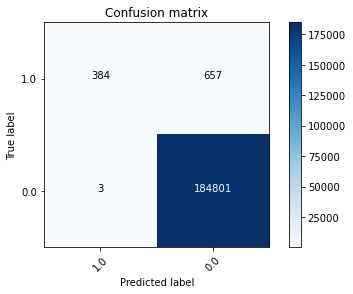

In [112]:
from sklearn.metrics import confusion_matrix

y_true_rf = predictions_rf.select("is_fraud")
y_true_rf = y_true_rf.toPandas()

y_pred_rf = predictions_rf.select("prediction")
y_pred_rf = y_pred_rf.toPandas()

cnf_matrix1 = confusion_matrix(y_true_rf, y_pred_rf,labels=class_names)
#cnf_matrix
plt.figure()
plot_confusion_matrix(cnf_matrix1, classes=class_names,
                      title='Confusion matrix')
plt.show()

### Precision, Recall and F1 Score

In [113]:
precision_rf = confusion_matrix_rf[1,1]/np.add(confusion_matrix_rf[0,1], confusion_matrix_rf[1,1])
print("Precision: ",precision_rf)
recall_rf = confusion_matrix_rf[1,1]/np.add(confusion_matrix_rf[1,0], confusion_matrix_rf[1,1])
print("recall: ",recall_rf)
f1_score_rf = 2*(precision_rf*recall_rf)/(precision_rf+recall_rf)
print("f1_score: ",f1_score_rf)

Precision:  0.9922480620155039
recall:  0.3688760806916426
f1_score:  0.5378151260504201


### ROC and Precision-Recall Curve

In [114]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Let's use the run-of-the-mill evaluator
evaluator = BinaryClassificationEvaluator(labelCol='is_fraud')

# We have only two choices: area under ROC and PR curves :-(
auroc_rf = evaluator.evaluate(predictions_rf, {evaluator.metricName: "areaUnderROC"})
auprc_rf = evaluator.evaluate(predictions_rf, {evaluator.metricName: "areaUnderPR"})
print("Area under ROC Curve: {:.4f}".format(auroc_rf))
print("Area under PR Curve: {:.4f}".format(auprc_rf))

Area under ROC Curve: 0.9893
Area under PR Curve: 0.8447


Area under ROC Curve: 0.9893
Area under PR Curve: 0.8447


<AxesSubplot:title={'center':'Precision-Recall Curve'}, xlabel='Recall', ylabel='Precision'>

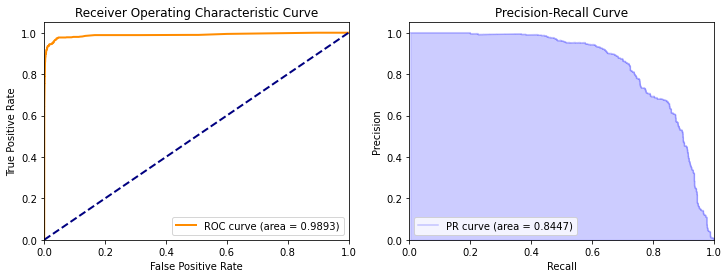

In [116]:
from handyspark import *
# Creates instance of extended version of BinaryClassificationMetrics
# using a DataFrame and its probability and label columns, as the output
# from the classifier
bcm = BinaryClassificationMetrics(predictions_rf, scoreCol='probability', labelCol='is_fraud')

# We still can get the same metrics as the evaluator...
print("Area under ROC Curve: {:.4f}".format(bcm.areaUnderROC))
print("Area under PR Curve: {:.4f}".format(bcm.areaUnderPR))

# But now we can PLOT both ROC and PR curves!
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
bcm.plot_roc_curve(ax=axs[0])
bcm.plot_pr_curve(ax=axs[1])

# We can also get all metrics (FPR, Recall and Precision) by threshold
#bcm.getMetricsByThreshold().filter('fpr between 0.19 and 0.21').toPandas()

# And get the confusion matrix for any threshold we want
#bcm.print_confusion_matrix(.415856)

### Hyperparameter Tuning on numTrees, impurity and maxDepth to try to improve the model

In [118]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

train_cv, hold_out_test_cv = df.randomSplit([0.9, 0.1])

numFolds = 3

rf_model_cv = classification.RandomForestClassifier(labelCol="is_fraud", featuresCol="finalfeatures", seed = 0)
evaluator_rfcv = BinaryClassificationEvaluator(metricName='areaUnderPR', labelCol='is_fraud')    

pipeline_rfcv = Pipeline(stages=[rf_model_cv])
paramGrid_rfcv = ParamGridBuilder()\
    .addGrid(rf_model_cv.numTrees, [10, 20, 30])\
    .addGrid(rf_model_cv.maxDepth, [3,5,10])\
    .addGrid(rf_model_cv.impurity, ['gini','entropy'])\
    .build()

crossval = CrossValidator(
    estimator=pipeline_rfcv,
    estimatorParamMaps=paramGrid_rfcv,
    evaluator=evaluator_rfcv,
    numFolds=numFolds)

rf_grid_model = crossval.fit(train_cv)

In [119]:
print("The best parameters for the random forest models are:\n ",rf_grid_model.getEstimatorParamMaps()[np.argmax(rf_grid_model.avgMetrics)])

The best parameters for the random forest models are:
  {Param(parent='RandomForestClassifier_f8511b0be0ae', name='numTrees', doc='Number of trees to train (>= 1).'): 30, Param(parent='RandomForestClassifier_f8511b0be0ae', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 10, Param(parent='RandomForestClassifier_f8511b0be0ae', name='impurity', doc='Criterion used for information gain calculation (case-insensitive). Supported options: entropy, gini'): 'gini'}


### Creating the best Random Forest Classifier

In [120]:
best_model_rf = rf_model_cv.setImpurity('gini').setMaxDepth(10).setNumTrees(30).fit(train_cv)

In [ ]:
# Feature Importance


In [121]:
best_rfPredictions = best_model_rf.transform(hold_out_test_cv)
best_predsAndLabels_rf = best_rfPredictions.select(['prediction','is_fraud']).\
                                withColumn('is_fraud', func.col('is_fraud').cast(FloatType())).orderBy('prediction')

In [122]:
# Precision, Recall and F1 Score

best_confusionMatrix_rf = MulticlassMetrics(best_predsAndLabels_rf.rdd.map(tuple)).confusionMatrix().toArray()
precision_rfBest = best_confusionMatrix_rf[1,1]/np.add(best_confusionMatrix_rf[0,1], best_confusionMatrix_rf[1,1])
print("Precision: ",precision_rfBest)
recall_rfBest = best_confusionMatrix_rf[1,1]/np.add(best_confusionMatrix_rf[1,0], best_confusionMatrix_rf[1,1])
print("recall: ",recall_rfBest)
f1_score_rfBest = 2*(precision_rfBest*recall_rfBest)/(precision_rfBest+recall_rfBest)
print("f1_score: ",f1_score_rfBest)

Precision:  0.9658002735978112
recall:  0.7415966386554622
f1_score:  0.8389780154486036


In [123]:
auroc_rfBest = evaluator.evaluate(best_rfPredictions, {evaluator.metricName: "areaUnderROC"})
auprc_rfBest = evaluator.evaluate(best_rfPredictions, {evaluator.metricName: "areaUnderPR"})
print("Area under ROC Curve for test data: {:.4f}".format(auroc_rfBest))
print("Area under PR Curve for test data: {:.4f}".format(auprc_rfBest))

Area under ROC Curve for test data: 0.9980
Area under PR Curve for test data: 0.9329


Area under ROC Curve: 0.9980
Area under PR Curve: 0.9336


<AxesSubplot:title={'center':'Precision-Recall Curve'}, xlabel='Recall', ylabel='Precision'>

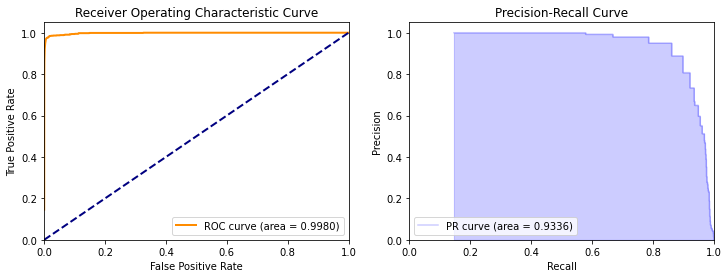

In [124]:
from handyspark import *
# Creates instance of extended version of BinaryClassificationMetrics
# using a DataFrame and its probability and label columns, as the output
# from the classifier
bcm_best_rf = BinaryClassificationMetrics(best_rfPredictions, scoreCol='probability', labelCol='is_fraud')

# We still can get the same metrics as the evaluator...
print("Area under ROC Curve: {:.4f}".format(bcm_best_rf.areaUnderROC))
print("Area under PR Curve: {:.4f}".format(bcm_best_rf.areaUnderPR))

# But now we can PLOT both ROC and PR curves!
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
bcm_best_rf.plot_roc_curve(ax=axs[0])
bcm_best_rf.plot_pr_curve(ax=axs[1])

# We can also get all metrics (FPR, Recall and Precision) by threshold
#bcm.getMetricsByThreshold().filter('fpr between 0.19 and 0.21').toPandas()

# And get the confusion matrix for any threshold we want
#bcm.print_confusion_matrix(.415856)

The best model gives us higher recall and precision.

### Visualization to understand the Best threshold value for classifying fraudulent and legitimate transactions.

Exception ignored in: <function JavaWrapper.__del__ at 0x7f2be19e9160>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.8/site-packages/pyspark/ml/wrapper.py", line 39, in __del__
    if SparkContext._active_spark_context and self._java_obj is not None:
AttributeError: 'BinaryClassificationEvaluator' object has no attribute '_java_obj'


Best Threshold: 0.30732443928718567 with F-Score: 0.8760775862068966
Recall: 0.8539915966386554, Precision: 0.8993362831858407


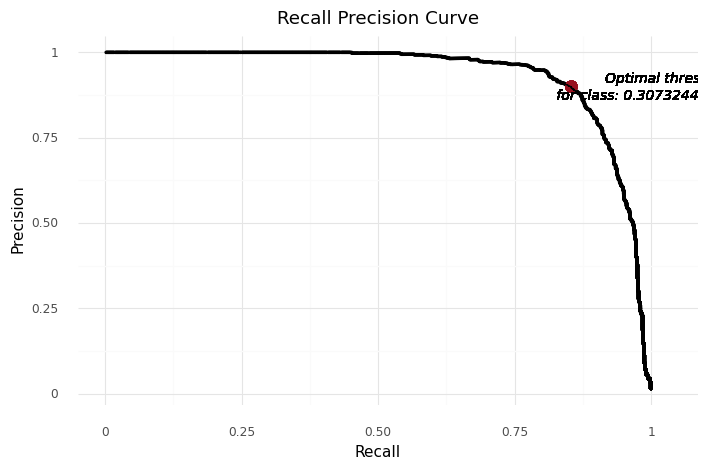

<ggplot: (8738593418855)>

In [125]:
# The precision-Recall curve for finding the optimal threshold
# https://medium.com/@douglaspsteen/precision-recall-curves-d32e5b290248

from pyspark.sql.functions import udf
from pyspark.sql.types import FloatType
from sklearn.metrics import precision_recall_curve   # Calculate the Precision-Recall curve
from sklearn.metrics import f1_score                 # Calculate the F-score
from plotnine import *
import plotnine

# creating a udf for extracting prob belonging to positive class
# https://stackoverflow.com/questions/44425159/access-element-of-a-vector-in-a-spark-dataframe-logistic-regression-probability

secondelement=udf(lambda v:float(v[1]),FloatType())

# creating pandas dataframe y_test and y_pred for sklearn where y_pred contains the probability of belonging to positive class
y_pred_rf = best_rfPredictions.select(secondelement('probability')).withColumnRenamed('<lambda>(probability)', 'pos_class_prob').toPandas()
y_test_rf = hold_out_test_cv.select('is_fraud').toPandas()


from sklearn.metrics import precision_recall_curve   # Calculate the Precision-Recall curve
from sklearn.metrics import f1_score                 # Calculate the F-score
# Import module for data visualization
from plotnine import *
import plotnine

# Create the Precision-Recall curve
precision, recall, thresholds = precision_recall_curve(y_test_rf, y_pred_rf)

# Plot the ROC curve
df_recall_precision_rf = pd.DataFrame({'Precision':precision[:-1],
                                    'Recall':recall[:-1],
                                    'Threshold':thresholds})

# Calculate the f-score
fscore = (2 * precision * recall) / (precision + recall)

# Find the optimal threshold
index = np.argmax(fscore)
thresholdOpt = thresholds[index]
fscoreOpt = fscore[index]
recallOpt = recall[index]
precisionOpt = precision[index]
print('Best Threshold: {} with F-Score: {}'.format(thresholdOpt, fscoreOpt))
print('Recall: {}, Precision: {}'.format(recallOpt, precisionOpt))

# Create a data viz
plotnine.options.figure_size = (8, 4.8)
(
    ggplot(data = df_recall_precision_rf)+
    geom_point(aes(x = 'Recall',
                   y = 'Precision'),
               size = 0.4)+
    # Best threshold
    geom_point(aes(x = recallOpt,
                   y = precisionOpt),
               color = '#981220',
               size = 4)+
    geom_line(aes(x = 'Recall',
                  y = 'Precision'))+
    # Annotate the text
    geom_text(aes(x = recallOpt,
                  y = precisionOpt),
              label = 'Optimal threshold \n for class: {}'.format(thresholdOpt),
              nudge_x = 0.18,
              nudge_y = 0,
              size = 10,
              fontstyle = 'italic')+
    labs(title = 'Recall Precision Curve')+
    xlab('Recall')+
    ylab('Precision')+
    theme_minimal()
)

# Gradient Boosting

## Default Model

In [51]:
from pyspark.ml import feature, classification

# default parameters
gbt_model = classification.GBTClassifier(featuresCol='finalfeatures', labelCol='is_fraud').\
    fit(train)

In [52]:
feature_importance_gbt = pd.DataFrame(list(zip(cols, gbt_model.featureImportances.toArray())),
            columns = ['feature', 'importance']).sort_values('importance', ascending=False)
feature_importance_gbt

,feature,importance
4,rolling_24h_avg_amt,0.237055
0,amt,0.196343
2,hour_of_transaction,0.182893
5,rolling_1_week_avg_amt,0.114201
7,number_trans_24h,0.087963
12,gender-vector,0.042914
11,category-vector,0.032012
8,number_trans_specific_day,0.023775
9,number_trans_month,0.022377
6,rolling_1month_avg_amt,0.016834


In [102]:
print('Area under PR curve for Gradient Boosted Trees on validation set: {0}'.format(bce.evaluate(gbt_model.transform(validate))))
# print('Area under PR curve for Gradient Boosted Trees on test set: {0}'.format(bce.evaluate(gbt_model.transform(test))))

Area under PR curve for Gradient Boosted Trees on validation set: 0.9069470285942144


In [53]:
from pyspark.sql.types import FloatType
from pyspark.mllib.evaluation import MulticlassMetrics

predictions_gbt = gbt_model.transform(test)
preds_and_labels_gbt = predictions_gbt.select(['prediction','is_fraud']).withColumn('is_fraud', func.col('is_fraud').cast(FloatType())).orderBy('prediction')

# getting the predicted probabilities
prob_gbt = predictions_gbt.select('probability')

## Confusion Matrix

In [54]:
confusion_matrix_gbt = MulticlassMetrics(preds_and_labels_gbt.rdd.map(tuple)).confusionMatrix().toArray()
confusion_matrix_gbt

array([[1.84715e+05, 8.90000e+01],
       [1.86000e+02, 8.55000e+02]])

Confusion matrix, without normalization
[[   855    186]
 [    89 184715]]


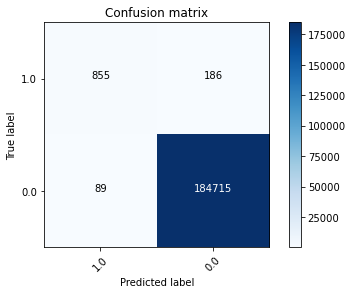

In [55]:
from sklearn.metrics import confusion_matrix

y_true_gbt = predictions_gbt.select("is_fraud")
y_true_gbt = y_true_gbt.toPandas()

y_pred_gbt = predictions_gbt.select("prediction")
y_pred_gbt = y_pred_gbt.toPandas()

cnf_matrix2 = confusion_matrix(y_true_gbt, y_pred_gbt,labels=class_names)
#cnf_matrix
plt.figure()
plot_confusion_matrix(cnf_matrix2, classes=class_names,
                      title='Confusion matrix for Gradient Boosting')
plt.show()

## Precision, Recall and F1 Score

In [57]:
precision_gbt = confusion_matrix_gbt[1,1]/np.add(confusion_matrix_gbt[0,1], confusion_matrix_gbt[1,1])
print("Precision: ",precision_gbt)
recall_gbt = confusion_matrix_gbt[1,1]/np.add(confusion_matrix_gbt[1,0], confusion_matrix_gbt[1,1])
print("recall: ",recall_gbt)
f1_score_gbt = 2*(precision_gbt*recall_gbt)/(precision_gbt+recall_gbt)
print("f1_score: ",f1_score_gbt)

Precision:  0.9057203389830508
recall:  0.8213256484149856
f1_score:  0.8614609571788413


## Area under PR Curve and ROC

In [59]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Let's use the run-of-the-mill evaluator
evaluator = BinaryClassificationEvaluator(labelCol='is_fraud')

# We have only two choices: area under ROC and PR curves :-(
auroc_gbt = evaluator.evaluate(predictions_gbt, {evaluator.metricName: "areaUnderROC"})
auprc_gbt = evaluator.evaluate(predictions_gbt, {evaluator.metricName: "areaUnderPR"})
print("Area under ROC Curve: {:.4f}".format(auroc_gbt))
print("Area under PR Curve: {:.4f}".format(auprc_gbt))

Area under ROC Curve: 0.9957
Area under PR Curve: 0.9193


## Precision-Recall Curve and ROC

Area under ROC Curve: 0.9957
Area under PR Curve: 0.9193


<AxesSubplot:title={'center':'Precision-Recall Curve'}, xlabel='Recall', ylabel='Precision'>

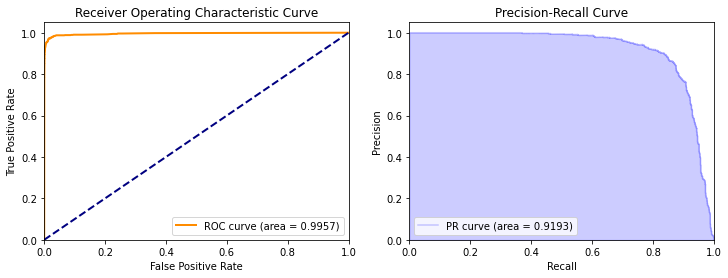

In [58]:
from handyspark import *
# Creates instance of extended version of BinaryClassificationMetrics
# using a DataFrame and its probability and label columns, as the output
# from the classifier
bcm = BinaryClassificationMetrics(predictions_gbt, scoreCol='probability', labelCol='is_fraud')

# We still can get the same metrics as the evaluator...
print("Area under ROC Curve: {:.4f}".format(bcm.areaUnderROC))
print("Area under PR Curve: {:.4f}".format(bcm.areaUnderPR))

# But now we can PLOT both ROC and PR curves!
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
bcm.plot_roc_curve(ax=axs[0])
bcm.plot_pr_curve(ax=axs[1])

# We can also get all metrics (FPR, Recall and Precision) by threshold
#bcm.getMetricsByThreshold().filter('fpr between 0.19 and 0.21').toPandas()

# And get the confusion matrix for any threshold we want
#bcm.print_confusion_matrix(.415856)

## Finding the optimal threshold for classifying a transaction as fraud to achieve the highest F1 score

Best Threshold: 0.47456419467926025 with F-Score: 0.8678304239401498
Recall: 0.8357348703170029, Precision: 0.9024896265560166


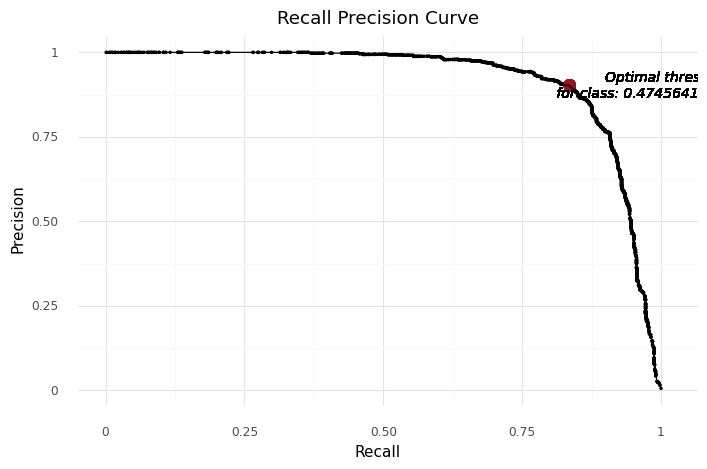

<ggplot: (8738525418548)>

In [126]:
# The precision-Recall curve for finding the optimal threshold

# creating pandas dataframe y_test and y_pred for sklearn where y_pred contains the probability of belonging to positive class
y_pred = predictions_gbt.select(secondelement('probability')).withColumnRenamed('<lambda>(probability)', 'pos_class_prob').toPandas()
y_test = test.select('is_fraud').toPandas()


from sklearn.metrics import precision_recall_curve   # Calculate the Precision-Recall curve
from sklearn.metrics import f1_score                 # Calculate the F-score
# Import module for data visualization
from plotnine import *
import plotnine

# Create the Precision-Recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)

# Plot the ROC curve
df_recall_precision_gbt = pd.DataFrame({'Precision':precision[:-1],
                                    'Recall':recall[:-1],
                                    'Threshold':thresholds})

# Calculate the f-score
fscore = (2 * precision * recall) / (precision + recall)

# Find the optimal threshold
index = np.argmax(fscore)
thresholdOpt = thresholds[index]
fscoreOpt = fscore[index]
recallOpt = recall[index]
precisionOpt = precision[index]
print('Best Threshold: {} with F-Score: {}'.format(thresholdOpt, fscoreOpt))
print('Recall: {}, Precision: {}'.format(recallOpt, precisionOpt))

# Create a data viz
plotnine.options.figure_size = (8, 4.8)
(
    ggplot(data = df_recall_precision_gbt)+
    geom_point(aes(x = 'Recall',
                   y = 'Precision'),
               size = 0.4)+
    # Best threshold
    geom_point(aes(x = recallOpt,
                   y = precisionOpt),
               color = '#981220',
               size = 4)+
    geom_line(aes(x = 'Recall',
                  y = 'Precision'))+
    # Annotate the text
    geom_text(aes(x = recallOpt,
                  y = precisionOpt),
              label = 'Optimal threshold \n for class: {}'.format(thresholdOpt),
              nudge_x = 0.18,
              nudge_y = 0,
              size = 10,
              fontstyle = 'italic')+
    labs(title = 'Recall Precision Curve')+
    xlab('Recall')+
    ylab('Precision')+
    theme_minimal()
)

# Combining results into DF

In [76]:
# initialize list of lists
data = [['Logistic Regression', precision_lr, recall_lr, f1_score_lr, auroc_lr, auprc_lr], \
        ['Random Forest', precision_rf, recall_rf, f1_score_rf, auroc_rf, auprc_rf], \
        ['Random Forest with Tuning', precision_rfBest, recall_rfBest, f1_score_rfBest, auroc_rfBest, auprc_rfBest], \
        ['Gradient Boosting Trees', precision_gbt, recall_gbt, f1_score_gbt, auroc_gbt, auprc_gbt]]
  
# Create the pandas DataFrame
results_df = pd.DataFrame(data, columns = ['Model', 'Precision',  'Recall', 'F1Score', 'AreaROC', 'AreaPRCurve'])
  
# print dataframe.
results_df

,Model,Precision,Recall,F1Score,AreaROC,AreaPRCurve
0,Logistic Regression,0.759766,0.373679,0.500966,0.960065,0.599438
1,Random Forest,0.980000,0.390000,0.780000,0.990000,0.820000
2,Gradient Boosting Trees,0.905720,0.821326,0.861461,0.995713,0.919254


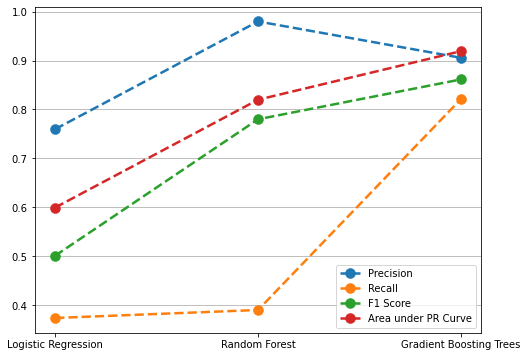

In [96]:
# plot lines
plt.figure(figsize=(8,6))
plt.plot(results_df.Model, results_df.Precision, label = "Precision", linestyle="--", linewidth=2.5, marker = 'o', markersize=10)
plt.plot(results_df.Model, results_df.Recall, label = "Recall", linestyle="--", linewidth=2.5, marker = 'o', markersize=10)
plt.plot(results_df.Model, results_df['F1Score'], label = "F1 Score", linestyle='--', linewidth=2.5, marker = 'o', markersize=10)
plt.plot(results_df.Model, results_df.AreaPRCurve, label = "Area under PR Curve", linestyle='--', linewidth=2.5, marker = 'o', markersize=10)
plt.legend()
plt.grid(axis = 'y')
plt.show()

# Rough

In [ ]:
from pyspark.ml.feature import Tokenizer
tokenizer = Tokenizer().setInputCol('job').setOutputCol('words')
tokenizer.transform(train_df_copy.select('job')).show()

In [ ]:
from pyspark.ml.feature import CountVectorizer
count_vectorizer_estimator = CountVectorizer().setInputCol('words').setOutputCol('features')
count_vectorizer_transformer = count_vectorizer_estimator.fit(tokenizer.transform(train_df_copy.select('job')))
count_vectorizer_transformer.transform(tokenizer.transform(train_df_copy.select('job'))).show()

In [ ]:
count_vectorizer_transformer.vocabulary


In [117]:
df[cols]

DataFrame[amt: double, city_pop: int, hour_of_transaction: int, distance: double, age: int, rolling_24h_avg_amt: double, rolling_1_week_avg_amt: double, rolling_1month_avg_amt: double, number_trans_24h: bigint, number_trans_specific_day: bigint, number_trans_month: bigint, weekly_avg_amt_over_3_months: double, category-vector: vector, gender-vector: vector, state-vector: vector, day_of_week-vector: vector]

In [161]:
train = df.sampleBy("is_fraud", fractions={0: 0.7, 1: 0.7}, seed=10)

  # Subtracting 'train' from original 'data' to get test set 
test = df.subtract(train)

In [162]:
train.groupBy('is_fraud').count().show()

+--------+-------+
|is_fraud|  count|
+--------+-------+
|       1|   6733|
|       0|1290089|
+--------+-------+



In [163]:
test.groupBy('is_fraud').count().show()

+--------+------+
|is_fraud| count|
+--------+------+
|       1|  2871|
|       0|553168|
+--------+------+



In [164]:
# Model training

from pyspark.ml.classification import LogisticRegression
from pyspark.ml import feature, classification

lr = LogisticRegression(featuresCol='finalfeatures', labelCol='is_fraud')
lr_model = lr.fit(train)
#predictions = lr_model.transform(validate)

In [165]:
from pyspark.sql.types import FloatType
from pyspark.mllib.evaluation import MulticlassMetrics
predictions = lr_model.transform(test)
preds_and_labels = predictions.select(['prediction','is_fraud']).withColumn('is_fraud', func.col('is_fraud').cast(FloatType())).orderBy('prediction')



#select only prediction and label columns
preds_and_labels = preds_and_labels.select(['prediction','is_fraud'])



confusion_matrix = MulticlassMetrics(preds_and_labels.rdd.map(tuple)).confusionMatrix().toArray()
confusion_matrix
precision = confusion_matrix[1,1]/np.add(confusion_matrix[0,1], confusion_matrix[1,1])
print("Precision: ",precision)
recall = confusion_matrix[1,1]/np.add(confusion_matrix[1,0], confusion_matrix[1,1])
print("recall: ",recall)
f1_score = 2*(precision*recall)/(precision+recall)
print("f1_score: ",f1_score)

Precision:  0.7247769389155799
recall:  0.367816091954023
f1_score:  0.4879852125693161


In [ ]:
confusion_matrix

In [ ]:
import statistics

predictionAndLabels = lr_model.transform(validate).select('is_','prediction')

tp = predictionAndLabels.where((predictionAndLabels.type == 1) & (predictionAndLabels.prediction == 1)).count()
tn = predictionAndLabels.where((predictionAndLabels.type == 0) & (predictionAndLabels.prediction == 0)).count()
fp = predictionAndLabels.where((predictionAndLabels.type == 0) & (predictionAndLabels.prediction == 1)).count()
fn = predictionAndLabels.where((predictionAndLabels.type == 1) & (predictionAndLabels.prediction == 0)).count()

precision = tp/(tp+fp)
recall = tp/(fn+tp)
data = [precision, recall]
f1_score = statistics.harmonic_mean(data)

In [142]:
numericalColumns = [t[0] for t in preprocessed_data.dtypes if ((t[1] != 'string') & (t[0] != 'is_fraud'))]
numericalColumns

['amt',
 'city_pop',
 'hour_of_transaction',
 'distance',
 'rolling_24h_avg_amt',
 'rolling_1_week_avg_amt',
 'rolling_1month_avg_amt',
 'number_trans_24h',
 'number_trans_specific_day',
 'number_trans_month',
 'weekly_avg_amt_over_3_months']

In [141]:
# creating the stages for Pipeline

from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler, StandardScaler
from pyspark.ml.classification import LogisticRegression

categoricalColumns = [t[0] for t in preprocessed_data.dtypes if t[1] == 'string']
categoricalColumns

['category', 'gender', 'day_of_week', 'age_udf_cat']

In [84]:
stages = []

for categoricalCol in categoricalColumns:
    stringIndexer = StringIndexer(inputCol=categoricalCol, outputCol=categoricalCol + 'Index')
    encoder = OneHotEncoder(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + 'classVec'])
    stages += [stringIndexer, encoder]

numericalColumns = [t[0] for t in combined_df_lr.dtypes if ((t[1] != 'string') & (t[0] != 'is_fraud'))]

assemblerInputs = [c + "classVec" for c in categoricalColumns] + numericalColumns
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

# scaler = StandardScaler(inputCol="vectorized_features", outputCol="features")
# stages += [scaler]

In [85]:
# creating the pipeline and transforming it to get the features.

from pyspark.ml import Pipeline
pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(combined_df_lr)
df = pipelineModel.transform(combined_df_lr)

In [109]:
from pyspark.ml import feature, classification

rf_model = classification.RandomForestClassifier(featuresCol='features', labelCol='is_fraud').\
    fit(df_train)

In [110]:
rf_model.transform(test)

DataFrame[category: string, amt: double, gender: string, state: string, city_pop: int, is_fraud: int, day_of_week: string, hour_of_transaction: int, age: int, distance: double, rolling_24h_avg_amt: double, rolling_1_week_avg_amt: double, rolling_1month_avg_amt: double, number_trans_24h: bigint, number_trans_specific_day: bigint, number_trans_month: bigint, weekly_avg_amt_over_3_months: double, categoryIndex: double, categoryclassVec: vector, genderIndex: double, genderclassVec: vector, stateIndex: double, stateclassVec: vector, day_of_weekIndex: double, day_of_weekclassVec: vector, features: vector, rawPrediction: vector, probability: vector, prediction: double]

In [117]:
df[cols]

DataFrame[amt: double, city_pop: int, hour_of_transaction: int, distance: double, age: int, rolling_24h_avg_amt: double, rolling_1_week_avg_amt: double, rolling_1month_avg_amt: double, number_trans_24h: bigint, number_trans_specific_day: bigint, number_trans_month: bigint, weekly_avg_amt_over_3_months: double, category-vector: vector, gender-vector: vector, state-vector: vector, day_of_week-vector: vector]

In [119]:
feature_importance = pd.DataFrame(list(zip(cols, rf_model.featureImportances.toArray())),
            columns = ['feature', 'importance']).sort_values('importance', ascending=False)

In [120]:
feature_importance

,feature,importance
5,rolling_24h_avg_amt,0.428874
6,rolling_1_week_avg_amt,0.221340
0,amt,0.108976
2,hour_of_transaction,0.084686
7,rolling_1month_avg_amt,0.067890
8,number_trans_24h,0.031970
10,number_trans_month,0.015911
11,weekly_avg_amt_over_3_months,0.010624
13,gender-vector,0.008395
9,number_trans_specific_day,0.004673


# EDA

In [ ]:
# distribution of amount

plt.figure(figsize=(10,5), dpi=100)

sns.histplot(data = train_df_pandas, x = 'amt', hue = 'amt')
plt.show()

In [ ]:
# Category

plt.figure(figsize=(10,5), dpi=100)

chart = sns.countplot(data = train_df_pandas, x = 'category'\
                      , order = train_df_pandas['category'].value_counts().index)
chart.set_xticklabels(chart.get_xticklabels(), rotation = 45, horizontalalignment = 'right')
plt.show()